# Import data

In [117]:
import os
import pandas as pd
import numpy as np
import scipy as sp

train = pd.read_csv("train.csv")
train_x = train.ix[:,:-1]
train_y = train.ix[:,-1]
test = pd.read_csv("test.csv")

In [2]:
# quick look at data
print train.head(10)
print train.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL           65     8450   Pave   NaN      Reg   
1   2          20       RL           80     9600   Pave   NaN      Reg   
2   3          60       RL           68    11250   Pave   NaN      IR1   
3   4          70       RL           60     9550   Pave   NaN      IR1   
4   5          60       RL           84    14260   Pave   NaN      IR1   
5   6          50       RL           85    14115   Pave   NaN      IR1   
6   7          20       RL           75    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM           51     6120   Pave   NaN      Reg   
9  10         190       RL           50     7420   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN    NaN         NaN       0   
1         Lvl    AllPub

In [4]:
# if test columns == train columns, and they do
test.columns == train.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [5]:
# datatypes
train_x.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

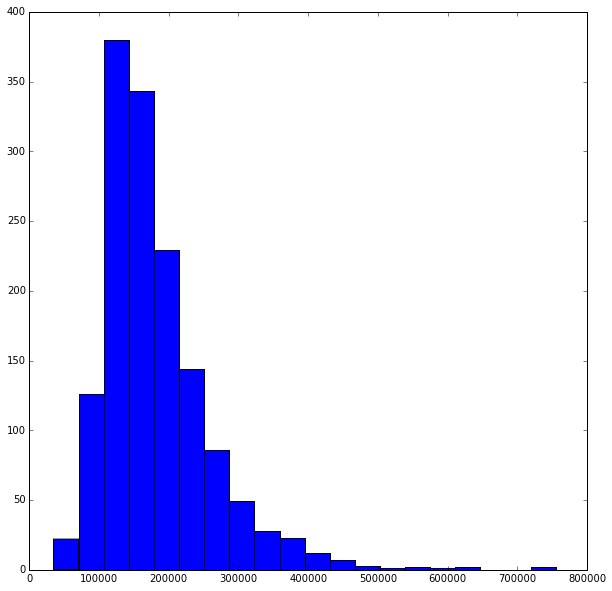

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
# the distribution of the target (SalePrice)
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist(train_y, bins = 20)
plt.show()

train_y.describe()

# Linear Regression w/ All Features

In [7]:
def dummy_transform(df):
    # create dummy columns 
    object_columns = df.columns[df.dtypes == 'object']
    #print object_columns.shape
    new_df = df[object_columns].fillna(value = "Nothing1") 
    object_dummies = pd.get_dummies(new_df, drop_first = True)
    #print object_dummies.shape
    
    # new dataframe 
    new_train_x = pd.concat([df, object_dummies], axis=1)
    nonobject_columns = new_train_x.columns[new_train_x.dtypes != "object"]
    #print nonobject_columns.shape
    nonobject_columns = nonobject_columns[1:] # removed id
    new_train_x = new_train_x[nonobject_columns]
    new_train_x.fillna(value = 0, inplace = True) 
    
    return(new_train_x)

In [8]:
# Dummy columns after test transformation, find columns that are the same in both sets
new_test_columns = dummy_transform(test).columns
new_train_columns = dummy_transform(train_x).columns

final_columns=new_test_columns & new_train_columns


TypeError: get_dummies() got an unexpected keyword argument 'drop_first'

In [ ]:
# model train
from sklearn.linear_model import LinearRegression

new_train_x = dummy_transform(train_x)[final_columns]
lm = LinearRegression()
lm.fit(new_train_x, train_y)

In [ ]:
# predict 
new_test_x = dummy_transform(test)[final_columns]
pred = lm.predict(new_test_x)
submission = pd.DataFrame({'Id': test.iloc[:,0], 'SalePrice': pred})
submission.loc[submission['SalePrice'] < 0,'SalePrice'] = 0 
submission.to_csv('initial_submission_LM.csv', index = False)

In [ ]:
# the distribution of predicted, there are negatives
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist(pred, bins = 20)
plt.suptitle('Predicted Distribution')
plt.xlim([0,700000])
plt.show()

pd.DataFrame(pred).describe()

# Understanding the Data

Ames is a city located in Iowa in Story County. In 2010 it had a population of 58,965. In 2010, Ames was ranked ninth on CNNMoney.com "Best Places to Live" list.

86% commute by car.
5% commute by public transportation.

Price per Square Ft. ranges from $130 - 140 from Jun 2015 - Jun 2016.

The median household income for the Ames Iowa metro area was $50,811 in 2015

In [ ]:
# year range
train['YrSold'].value_counts()

In [ ]:
# plot year vs sale price, it looks like all the median sale prices are around the same.
import seaborn as sns
sns.set(style="ticks")
sns.boxplot(x='YrSold', y='SalePrice', data=train, palette="PRGn")

In [ ]:
# Lot Area vs Sale Price, based on the scatter plot lot area does not affect the price much. There are a few outliers
# that we should look into compared to the ones in the left cluster.
ax = sns.lmplot(x='GrLivArea',y='SalePrice',
                data=train ,fit_reg=True, 
                aspect = 2, line_kws={'color': 'red'})

ax.axes[0,0].set_ylim(0,800000)

print train['GrLivArea'].describe()

print train[['GrLivArea','SalePrice']].corr()

sns.plt.show()

C:\Users\Moyp\dev\anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


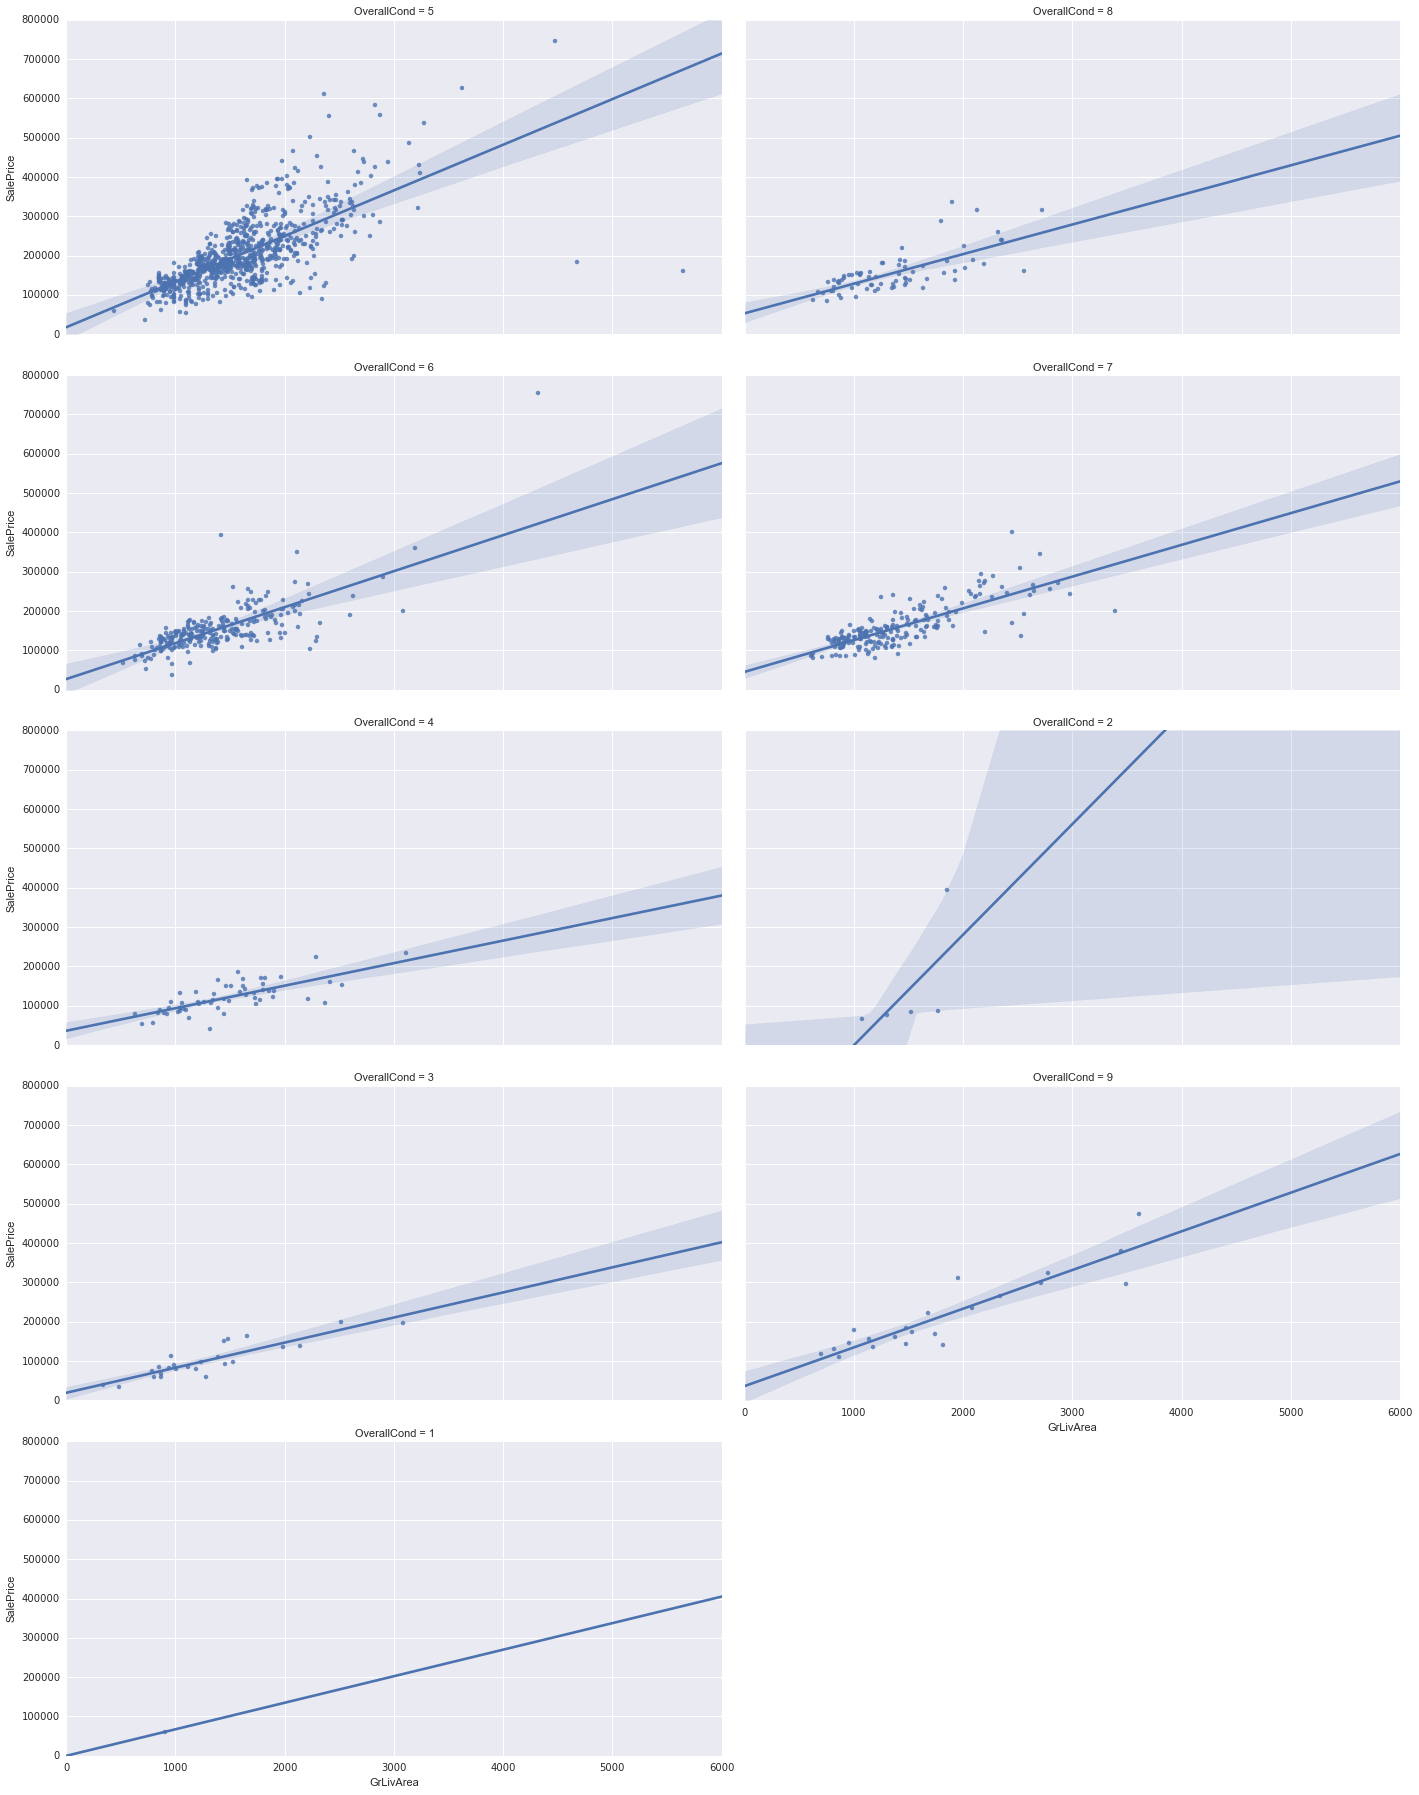

In [9]:
import seaborn as sns
from  matplotlib import pyplot

data = train[['GrLivArea','SalePrice','OverallCond']]
ax = sns.lmplot(data = data, x = 'GrLivArea', 
                y = 'SalePrice', col = 'OverallCond', 
                fit_reg = True, aspect = 2,
                col_wrap = 2)
ax.set(ylim=(0, 800000))
ax.set(xlim=(0, 6000))

sns.plt.show()

In [17]:
# correlation plot with all numeric features
numeric_features = train.dtypes[train.dtypes != 'object'].index
pearson = train[numeric_features].corr(method='pearson')
corr_with_target = pearson.ix[-1][1:-1]
corr_with_target = corr_with_target[abs(corr_with_target).argsort()[::-1]]
print corr_with_target

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64


C:\Users\Moyp\dev\anaconda\lib\site-packages\seaborn-0.6.0-py2.7.egg\seaborn\linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Users\Moyp\dev\anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Moyp\dev\anaconda\lib\site-packages\seaborn-0.6.0-py2.7.egg\seaborn\linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


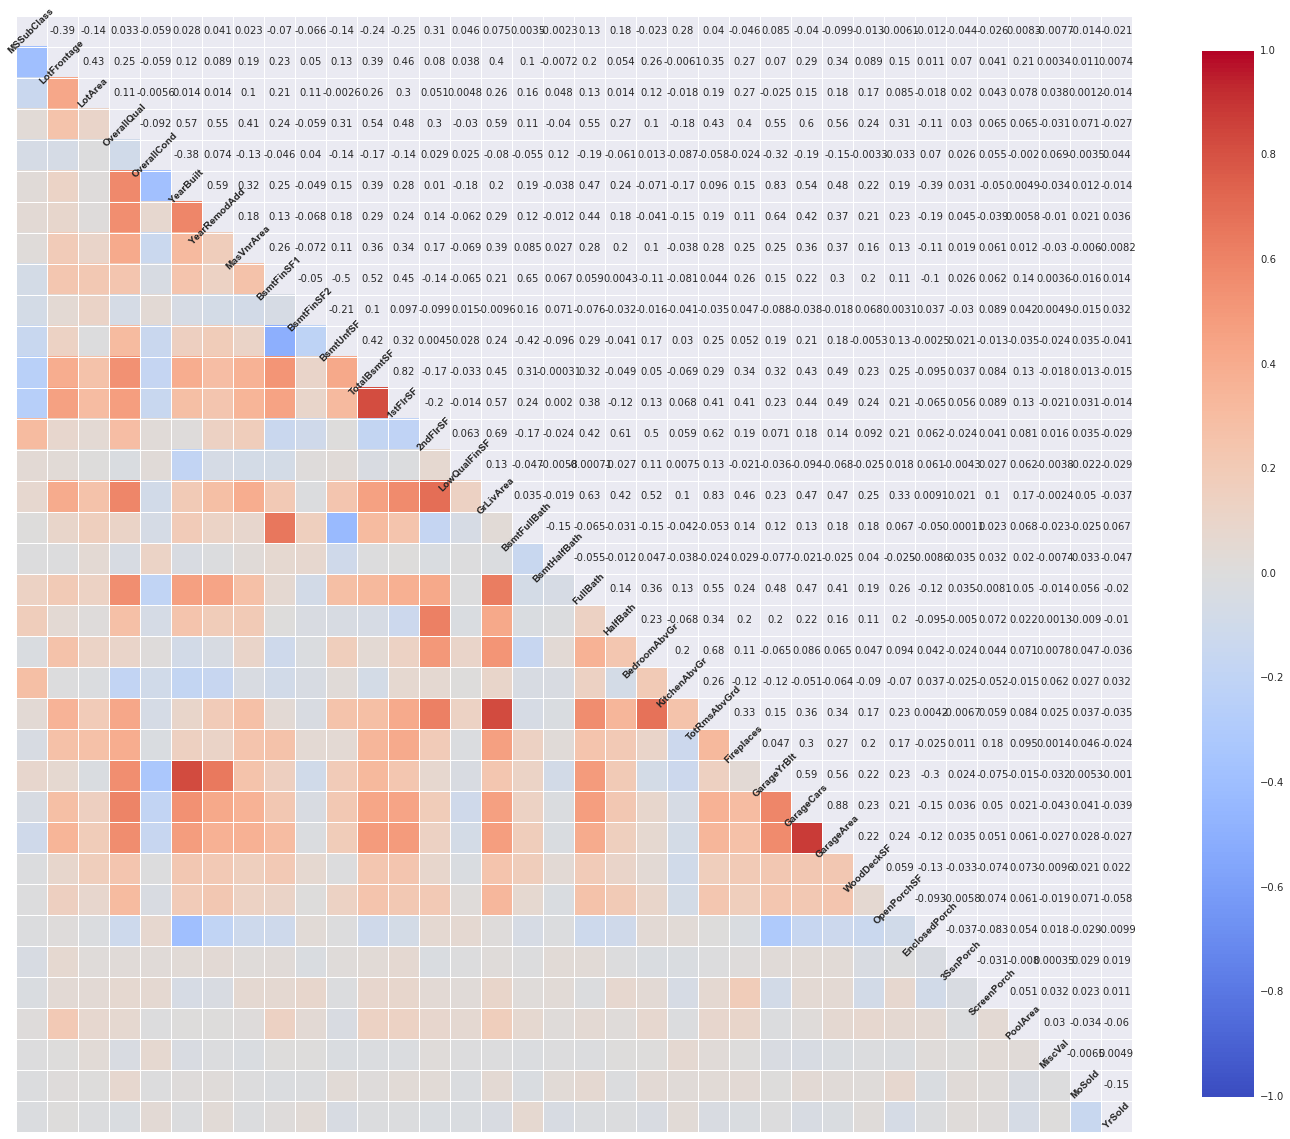

In [11]:
#TotalBsmtSF and 1stFlrSF have .82 correlation
#YearBuilt and GarageYrBuilt have .83 correlation
#GrLivArea and TotRmsAbvGrd have .83 correlation
#GarageCars and GarageArea have .88 correlation
#BsmtFinSF2 and BsmtUntSF have -.5 correlation highest negative
# make a plot of specified dimension (in inches), just a 1x1 subplot
fig, ax = plt.subplots(figsize=(25, 25))
# pass the axis to draw on
sns.corrplot(train[numeric_features[1:-1]], ax=ax)


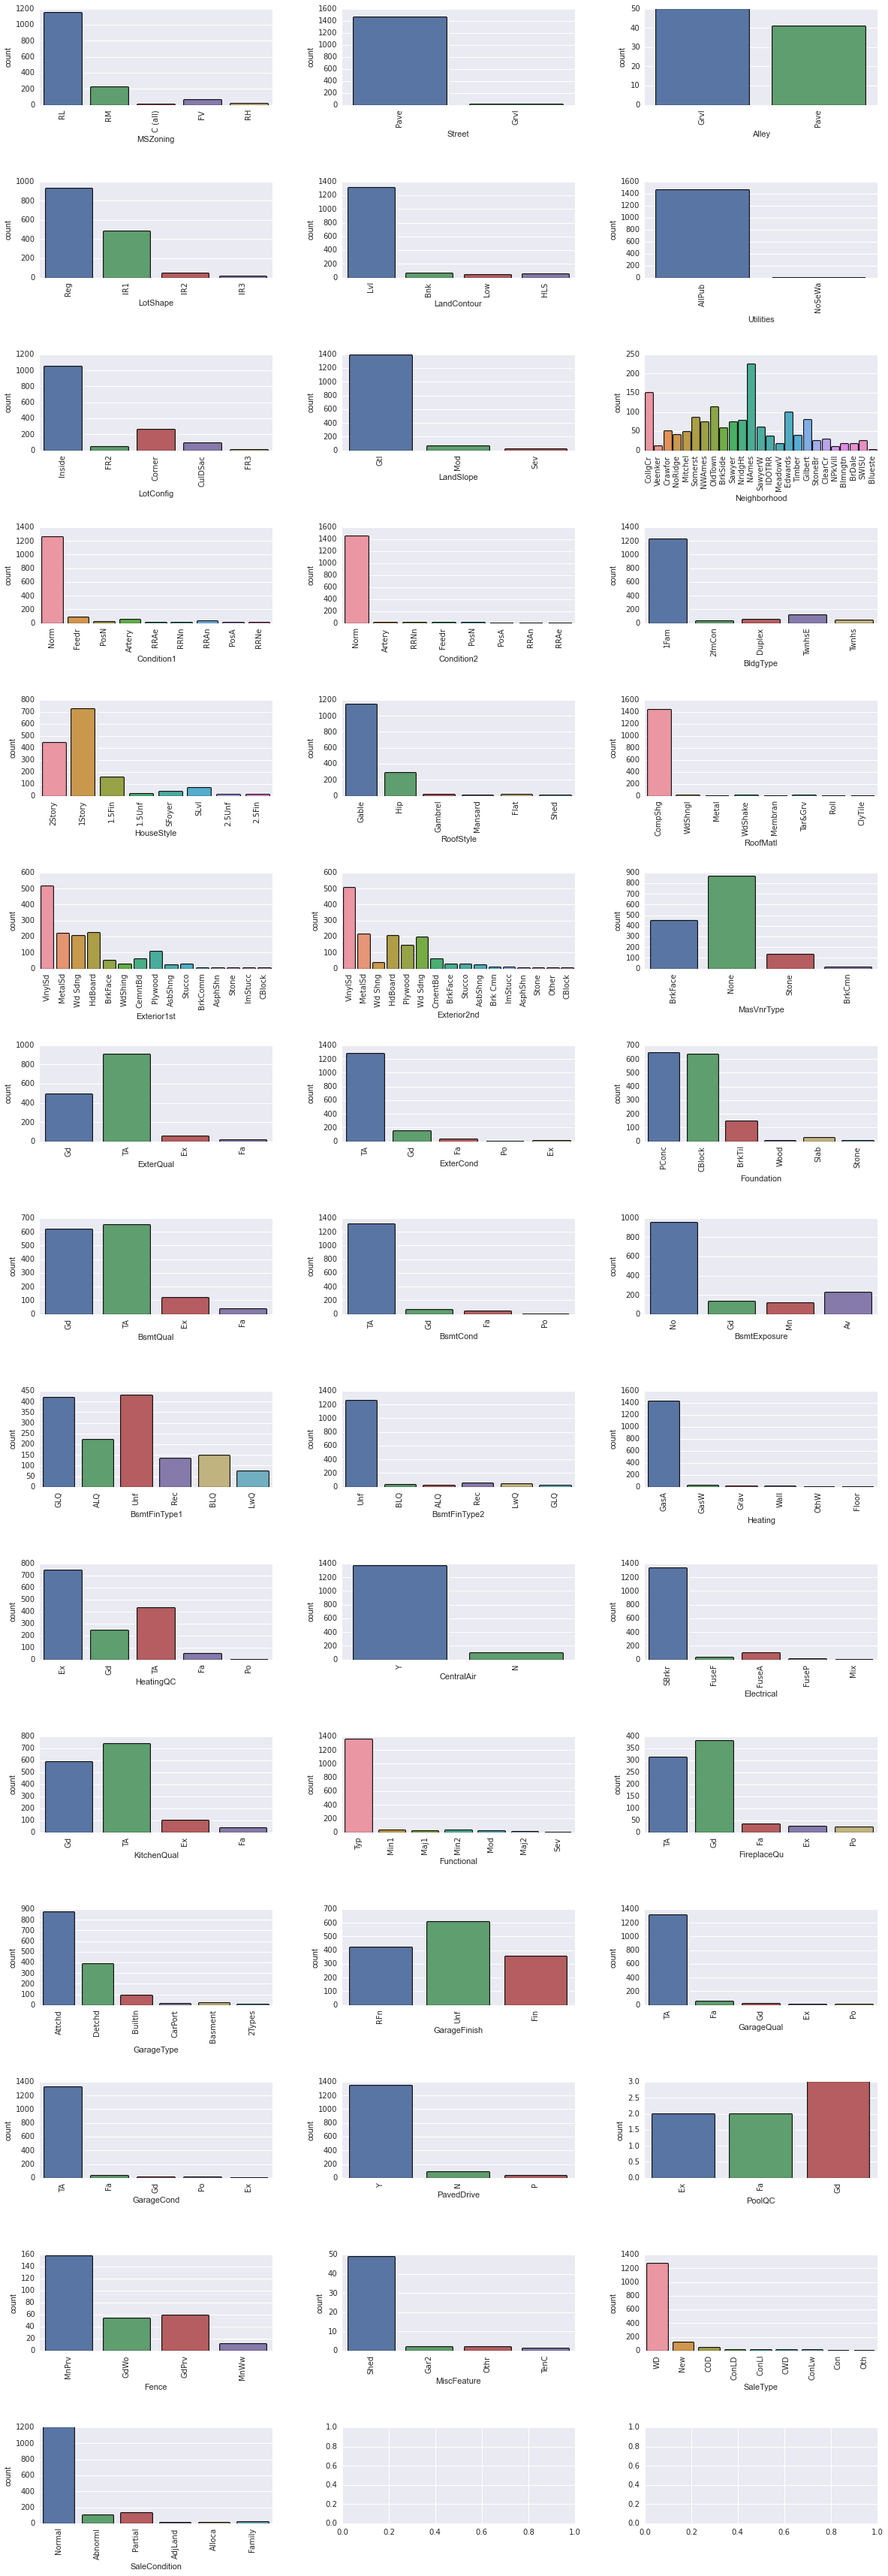

In [12]:
#object features
object_features = train.dtypes[train.dtypes == 'object'].index
n_features1 = 10
n_rows = 15
object_df = train[object_features]

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)


for k in axs:
    for i,j in zip(object_features, axs.flat):
        g = sns.countplot(x=i, data=object_df, ax=j)
        plt.setp(j.get_xticklabels(), rotation=90)

In [142]:
# columns with NAs and count
from __future__ import division
print "Train Columns with Nulls \n"
train_nulls = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_nulls.append(column)
        
#test
test_nulls = []
print "\nTest Columns with Nulls \n"
for column in test.columns:
    if test[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_nulls.append(column)
        


Train Columns with Nulls 


Test Columns with Nulls 



In [119]:
# there seems to be a lot of nulls in a lot of columns, lets put a 10% constraint on it,
# The train columns are equal to test columns. The percentages are about the same. Alley, PoolQC,
# Fence, and MiscFeature have a high percentage of nulls which means there is a lot of missing data.
# it is probably ok to drop these columns.

limit = .70
#train
train_nulls_less_70 = []
train_remove = []
print "Train Columns with Nulls > 70%\n"
for column in train_nulls:
    if float(train[column].isnull().sum()/len(train)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_remove.append(column)
    else:
        train_nulls_less_70.append(column)
        
#test
test_nulls_less_70 = []
test_remove = []
print "\nTest Columns with Nulls > 70%\n"
for column in test_nulls:
    if float(test[column].isnull().sum()/len(test)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_remove.append(column)
    else:
        test_nulls_less_70.append(column)
        


Train Columns with Nulls > 70%

Column: Alley has 1369 nulls which is 94.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls > 70%

Column: Alley has 1352 nulls which is 93.0%
Column: PoolQC has 1456 nulls which is 100.0%
Column: Fence has 1169 nulls which is 80.0%
Column: MiscFeature has 1408 nulls which is 97.0%


In [120]:
# remove the columns from train and test
train.drop(train_remove, axis = 1, inplace = True)
test.drop(test_remove, axis = 1, inplace = True)

In [121]:
print train_nulls_less_70
#Electrical null is not part of factors
train_columns_true_null = {'Electrical':['Utilities','YearBuilt','Heating','HeatingQC','CentralAir']}
train_columns_null = [item for item in train_nulls_less_70 if item not in train_columns_true_null.keys()]

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [133]:
# replace the train null columns
for column in train_columns_null:
    if train[column].dtype == 'float64':
        train.ix[train[column].isnull(), column] = 0
    else:
        train.ix[train[column].isnull(), column] = 'None'

In [140]:
print test_nulls_less_70
#null not part of factors
test_columns_true_null = {'MSZoning':['LotShape','LandContour','LandSlope','Neighborhood'],
                          'Utilities':['YearBuilt','Heating','HeatingQC','CentralAir'],
                          'Exterior1st':['RoofStyle','MasVnrType','Foundation'],
                          'Exterior2nd':['RoofStyle','MasVnrType','Foundation'],
                          'KitchenQual':['OverallQual','OverallCond','Functional'],
                          'Functional':['KitchenQual','OverallQual','OverallCond']}
test_columns_null = [item for item in test_nulls_less_70 if item not in test_columns_true_null.keys()]
#SaleType (change to Other)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [135]:
# replace the test null columns
for column in test_columns_null:
    if test[column].dtype == 'float64':
        test.ix[test[column].isnull(), column] = 0
    elif column == 'SaleType':
        test.ix[test[column].isnull(), column] = 'Oth'
    else:
        test.ix[test[column].isnull(), column] = 'None'

### Find Nulls and Replace
The function below replaces the nulls values that are not part of the column's categories. For example Electrical has the following categories:

    SBrkr	Standard Circuit Breakers & Romex
    FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
    FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
    FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
    Mix	Mixed

a null will be just be a missing data point. I will find columns relevant to the null value's column in question. I will take the values for the relevant columns associated with the null value and find existing observations with the same values. If they are match I will record it and in the end take the value with the most occurences and set the null value as it.

In [123]:
def find_nulls_and_similar_then_replace(df, null_column, rel_columns):
    #try to find similar obsverations like null MSZoning
    null_values = df[df[null_column].isnull()]\
    [rel_columns].values

    num_nulls = len(null_values) #number of nulls
    num_rel_columns = len(rel_columns) #number of relevant columns

    not_null_values = df[df[null_column].notnull()]\
    [rel_columns]

    similar_values = {sec : [] for sec in range(0,num_nulls)}#index of similar no null values to null values

    for key, values in enumerate(null_values):
        for index, row in not_null_values.iterrows(): #iterate over all rows
            if (row.values == values).sum() >= (num_rel_columns - 1): #if greater than equal to num_rel_columns - 1 
                similar_values[key].append(df.ix[index,null_column]) #append to list

    replace_nulls(df, null_column, similar_values)

In [124]:
from collections import Counter

def replace_nulls(df, column, similar_values):
    
    most_common_value = []
    
    for key in similar_values:
        most_common_value.append(Counter(similar_values[key]).most_common(1)[0][0]) #most common value is appended to list

    df.ix[df[column].isnull(),column] = most_common_value #replace nulls


In [125]:
#Train
for key, value in train_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(train,key,value)

In [144]:
#Test - MSZoning
for key, value in test_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(test,key,value)

In [148]:
#lets see if it worked, it did!
print train.isnull().values.any()
print test.isnull().values.any()

False
False


In [155]:
#reset the x y variables
train_x = train.ix[:,:-1]
train_y = train.ix[:,-1]

train_x.columns == test.columns #check columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)